In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_dir = 'C:/Users/User/Documents/Dataset Skripsi/Side'
os.listdir(data_dir)

['Critical', 'Good']

In [ ]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:  {}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 4

train_datagen = ImageDataGenerator( rescale=1./255, validation_split=0.2,

                                    # augmentation execute randomly state
                                    # choose the augmentation setting (you can combine the setting)
                                    horizontal_flip = True,
                                    vertical_flip = True,
#                                     rotation_range = 40,
#                                     width_shift_range = [-100, -50, 0, 50, 100],
#                                     height_shift_range = [-50, 0, 50],
#                                     zoom_range = 0.5,
#                                     shear_range=40,

#                                     channel_shift_range = 100,
                                    brightness_range = (0.5, 2),
                                  )

train_generator = train_datagen.flow_from_directory(
        data_dir, seed=10,
        target_size=image_size,
        batch_size=batch_size,
        subset='training',
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        data_dir, seed=10,
        target_size=image_size,
        batch_size=batch_size,
        subset='validation',
        class_mode='categorical')


Found 132 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [ ]:
def get_array(generator, y_only=True):
    data_listX = []
    data_listY = []
    batch_index = 0
    while batch_index <= generator.batch_index:
        data = generator.next()
        if not y_only:
            data_listX.append(data[0])
        data_listY.append(data[1])
        batch_index = batch_index + 1
    if not y_only:
        return np.concatenate(data_listX,0), np.concatenate(data_listY,0) 
    return np.concatenate(data_listY,0) 
# now, data_array is the numeric data of whole images label
X_train, y_train = get_array(train_generator, y_only=False)
X_valid, y_valid = get_array(validation_generator, y_only=False)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from tensorflow.keras.applications import MobileNetV2, ResNet50, inception_v3, densenet, mobilenet, mobilenet_v2

inputs = layers.Input(shape=(*image_size,3))
backbone = mobilenet_v2.MobileNetV2(include_top=False, input_tensor=inputs, weights='imagenet')
x = backbone.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              # optimizer=RMSprop(lr=0.00001),
              metrics=['acc','AUC', TruePositives(name='TP'), TrueNegatives(name='TN'), FalsePositives(name='FP'), FalseNegatives(name='FN')])

# checkpoint
filepath="weights_best_resnet.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_TP', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

C:\Users\User\anaconda3\envs\ammoqc\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training

In [ ]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.arange(train_generator.num_classes), y = np.argmax(y_train,1))
class_weights = dict(enumerate(class_weights))

In [ ]:
model.fit(
      X_train, y_train,
      epochs=25,
      batch_size=batch_size,
      validation_data=(X_valid, y_valid),
      callbacks=callbacks_list,
      class_weight=class_weights,
      verbose=2)

Epoch 1/25

Epoch 1: val_TP did not improve from 32.00000
33/33 - 13s - loss: 0.0909 - acc: 0.9545 - auc: 0.9959 - TP: 126.0000 - TN: 126.0000 - FP: 6.0000 - FN: 6.0000 - val_loss: 0.0879 - val_acc: 0.9375 - val_auc: 0.9961 - val_TP: 30.0000 - val_TN: 30.0000 - val_FP: 2.0000 - val_FN: 2.0000 - 13s/epoch - 403ms/step
Epoch 2/25

Epoch 2: val_TP did not improve from 32.00000
33/33 - 12s - loss: 0.0737 - acc: 0.9848 - auc: 0.9894 - TP: 130.0000 - TN: 130.0000 - FP: 2.0000 - FN: 2.0000 - val_loss: 0.0822 - val_acc: 0.9688 - val_auc: 0.9971 - val_TP: 31.0000 - val_TN: 31.0000 - val_FP: 1.0000 - val_FN: 1.0000 - 12s/epoch - 364ms/step
Epoch 3/25

Epoch 3: val_TP did not improve from 32.00000
33/33 - 12s - loss: 0.1194 - acc: 0.9621 - auc: 0.9933 - TP: 127.0000 - TN: 127.0000 - FP: 5.0000 - FN: 5.0000 - val_loss: 1.1018 - val_acc: 0.8125 - val_auc: 0.8750 - val_TP: 26.0000 - val_TN: 26.0000 - val_FP: 6.0000 - val_FN: 6.0000 - 12s/epoch - 375ms/step
Epoch 4/25

Epoch 4: val_TP did not improve

Text(0.5, 1.0, 'Training and validation loss')

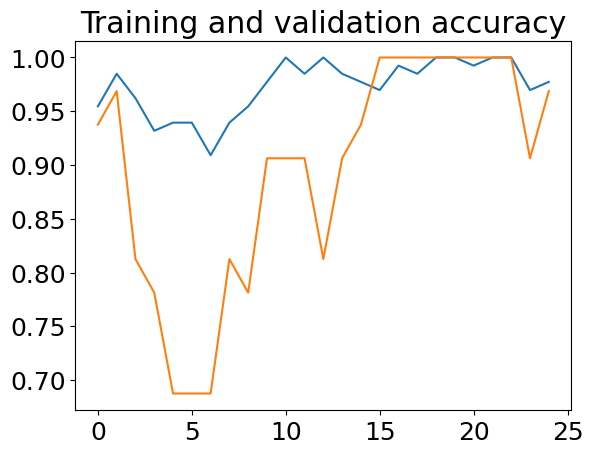

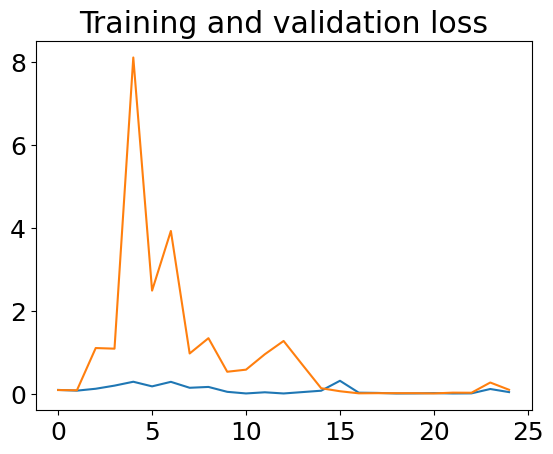

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
model.load_weights(filepath)

In [ ]:
prediction = model.predict(X_valid)

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, f1_score
plt.rc('font', size=18)
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    PLT = plt.figure(figsize=(6*int(np.sqrt(len(target_names))), 4*int(np.sqrt(len(target_names)))))
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=-90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label (ACC={:0.4f})'.format(accuracy))
    return PLT

C:\Users\User\AppData\Local\Temp\ipykernel_11756\1968698831.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  PLT.show()


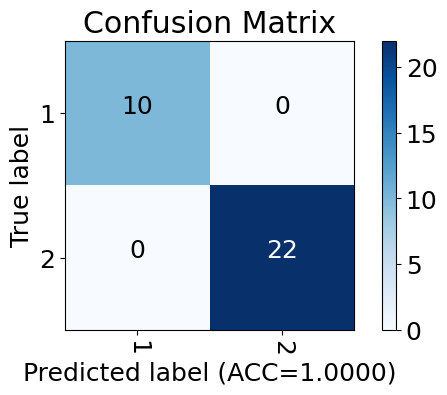

In [ ]:
from sklearn.metrics import confusion_matrix
labels=['1','2','3','4','5','6','7','8','9','blank'][:train_generator.num_classes]
y_true = [labels[c] for c in np.argmax(prediction,1)]
y_pred = [labels[c] for c in np.argmax(y_valid,1)]
cm = confusion_matrix(y_true, y_pred, labels=labels)
PLT = plot_confusion_matrix(cm, labels, title="Confusion Matrix", cmap=None, normalize=False)
PLT.show()

In [ ]:
model.save('kerasmobilenev2-batchsize4.h5')